# 06 — Article Tagging & Reading History

**Steps covered:**
1. Display synthetic users and interest dictionary
2. Tag CNH-PSX articles using keyword matching
3. Tag Pakistan News articles
4. Combine into a single article pool
5. Simulate reading history for each user → save reading_log.csv

In [1]:
import sys
sys.path.append('../src')

import pandas as pd
import matplotlib.pyplot as plt

from user_profile import SYNTHETIC_USERS, SECTOR_KEYWORDS
from article_tagger import tag_articles, combine_tagged_datasets
from history_simulator import simulate_reading_history, get_reading_log

df_cnhpsx = pd.read_csv('../data/processed/cnhpsx_clean.csv')
df_news   = pd.read_csv('../data/processed/pakistan_news_clean.csv')

print('CNH-PSX:', df_cnhpsx.shape)
print('Pakistan News:', df_news.shape)

CNH-PSX: (8858, 5)
Pakistan News: (25912, 5)


## Step 1 — Synthetic Users & Interest Dictionary

In [2]:
print('Synthetic Users ')
for user in SYNTHETIC_USERS:
    print(f'  {user}')

print('\nInterest Dictionary (10 keywords per sector)')
for sector, keywords in SECTOR_KEYWORDS.items():
    print(f'\n{sector}:')
    for kw in keywords:
        print(f'  - {kw}')

Synthetic Users 
  SyntheticUser(id=User_1, sector=Construction, sub_focus=cement-heavy, clicks=0)
  SyntheticUser(id=User_2, sector=Construction, sub_focus=infrastructure-heavy, clicks=0)
  SyntheticUser(id=User_3, sector=Banking, sub_focus=None, clicks=0)
  SyntheticUser(id=User_4, sector=Energy, sub_focus=None, clicks=0)

Interest Dictionary (10 keywords per sector)

Construction:
  - luck
  - dgkc
  - fccl
  - maple leaf cement
  - cement
  - concrete
  - construction
  - infrastructure
  - housing scheme
  - psdp
  - capacity expansion

Banking:
  - mebl
  - habib bank
  - hbl
  - united bank
  - ubl
  - national bank
  - nbp
  - state bank
  - sbp
  - policy rate
  - interest rate
  - net interest margin
  - deposits
  - dividend payout

Energy:
  - ogdc
  - oil and gas development
  - ppl
  - pakistan petroleum
  - pso
  - pakistan state oil
  - crude oil
  - exploration
  - refinery
  - gas production
  - fuel prices
  - circular debt


## Step 2 — Tag CNH-PSX Articles

In [3]:
# tag using raw headline — more keywords visible before cleaning
df_cnhpsx_tagged = tag_articles(df_cnhpsx, text_col='headline')

print('\nSample tagged articles:')
print(df_cnhpsx_tagged[df_cnhpsx_tagged['primary_tag'] != 'Other'][['headline', 'primary_tag', 'tags']].head(10))

[Tagger] 1826/8858 articles tagged (20.6%)
  Construction: 51
  Banking: 1011
  Energy: 764
  Other: 7032

Sample tagged articles:
                                              headline   primary_tag  \
57   ['Energy, cement shares help KSE gain 94 points']  Construction   
92       ['Buying in cement averts big losses at KSE']  Construction   
269      ['KSE further up on buying in cement stocks']  Construction   
284  ['PSO sell off delay fuels bearish drive at KSE']        Energy   
285  ['Cement, banking, oil scrips push KSE up by 1...  Construction   
334                       ['KSE approves HBL listing']       Banking   
377  ['KSE above 14,000 points on buying in cement,...  Construction   
510  ['KSE gains 138 points on buying in banking, c...  Construction   
552     ['KSE falls 861 points on interest rate hike']       Banking   
589  ['KSE breaks decade low turnover record in abs...       Banking   

               tags  
57   [Construction]  
92   [Construction]  
269  [Cons

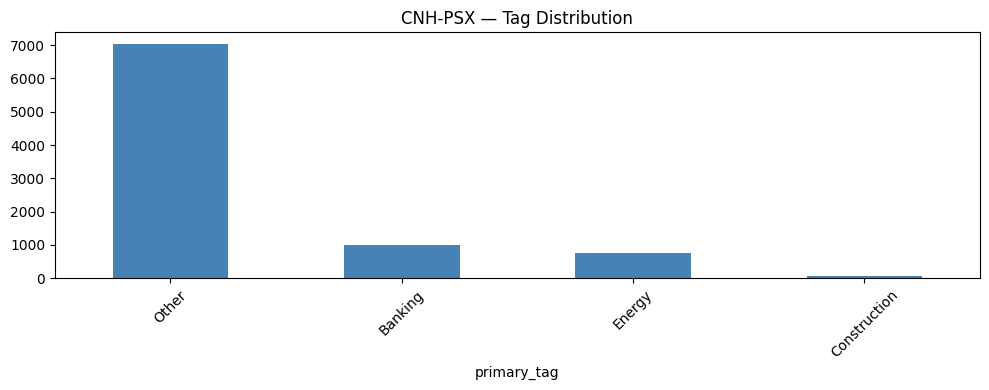

In [4]:
# Visualize tag distribution for CNH-PSX
df_cnhpsx_tagged['primary_tag'].value_counts().plot(
    kind='bar', figsize=(10, 4),
    title='CNH-PSX — Tag Distribution',
    color='steelblue'
)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Step 3 — Tag Pakistan News Articles

In [5]:
# Tag using full text (heading + excerpt) for better coverage
df_news_tagged = tag_articles(df_news, text_col='text_combined')

print('\nSample tagged articles:')
print(df_news_tagged[df_news_tagged['primary_tag'] != 'Other'][['heading', 'primary_tag']].head(10))

[Tagger] 325/25912 articles tagged (1.3%)
  Construction: 134
  Banking: 133
  Energy: 58
  Other: 25587

Sample tagged articles:
                                                heading   primary_tag
161          CCP launches probe into 62 housing schemes  Construction
181   30 fishing boats destroyed by sea current in G...  Construction
438                 4pc growth target to be missed: SBP       Banking
500   PSO dues, Wapda loans and Tapi on second ECC m...        Energy
611        Gas shortfall set to almost double next year        Energy
958   Housing society approved for PAF martyrs defra...  Construction
996     Huge sinkhole swallows bus, kills nine in China  Construction
1033  Thousands of litres of diesel leaks in Karachi...        Energy
1079          Govt raises Rs274.7bn from T-bill auction       Banking
1321         Ahsan aims to cement spot in Pakistan team  Construction


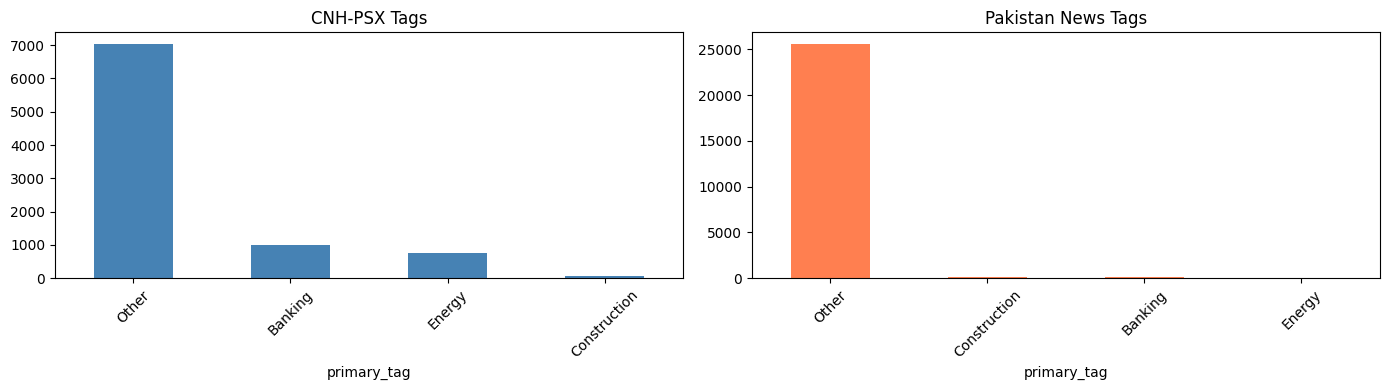

In [6]:
# Side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

df_cnhpsx_tagged['primary_tag'].value_counts().plot(
    kind='bar', ax=axes[0], title='CNH-PSX Tags', color='steelblue')
axes[0].tick_params(axis='x', rotation=45)

df_news_tagged['primary_tag'].value_counts().head(8).plot(
    kind='bar', ax=axes[1], title='Pakistan News Tags', color='coral')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Step 4 — Combine into Article Pool

In [7]:
df_pool = combine_tagged_datasets(df_cnhpsx_tagged, df_news_tagged)

print('\nPool by source:')
print(df_pool['source'].value_counts())
print('\nPool by tag:')
print(df_pool['primary_tag'].value_counts())

[Pool] Combined pool: 34770 articles
primary_tag
Other           32619
Banking          1144
Energy            822
Construction      185

Pool by source:
source
pakistan_news    25912
cnhpsx            8858
Name: count, dtype: int64

Pool by tag:
primary_tag
Other           32619
Banking          1144
Energy            822
Construction      185
Name: count, dtype: int64


## Step 5 — Simulate Reading History

In [8]:
# 10 clicks per user, 10% noise from other sectors
users = simulate_reading_history(
    users=SYNTHETIC_USERS,
    df_tagged=df_pool,
    n_clicks=10,
    noise_ratio=0.1,
    seed=42
)

[History] User_1 (Construction / cement-heavy): 9 sector + 1 noise clicks
[History] User_2 (Construction / infrastructure-heavy): 9 sector + 1 noise clicks
[History] User_3 (Banking / None): 9 sector + 1 noise clicks
[History] User_4 (Energy / None): 9 sector + 1 noise clicks


In [9]:
# export and inspect reading log
reading_log = get_reading_log(users, df_pool)
print(reading_log.to_string())
reading_log.to_csv('../data/processed/reading_log.csv', index=False)
print('\nSaved to data/processed/reading_log.csv')

   user_id        sector  article_id                                                                                                                                                        headline   primary_tag
0   User_1  Construction       13791                                                                                                                                                        Pakistan  Construction
1   User_1  Construction       10547                                                                                              WB-funded plan to improve city’s municipal infrastructure launched  Construction
2   User_1  Construction          92                                                                                                                   ['Buying in cement averts big losses at KSE']  Construction
3   User_1  Construction       12703                                                                                                                        

In [10]:
# save pool for next notebook
df_pool.to_csv('../data/processed/article_pool.csv', index=False)
print('Article pool saved to data/processed/article_pool.csv')

Article pool saved to data/processed/article_pool.csv


## Conclusions
- [ ] CNH-PSX articles tagged: ... / 8858
- [ ] Pakistan News articles tagged: ... / 25912
- [ ] Combined pool size: ...
- [ ] Reading log looks correct: yes/no
- [ ] Ready for 07_profile_vectors: yes/no